In [151]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette='pastel')
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

In [2]:
def process_features(df):
    tmp = df.copy()
    tmp['date'] = pd.to_datetime(df['date'])
    tmp['month'] = tmp.date.dt.month
    tmp['year'] = tmp.date.dt.year
    tmp['most_recent_renov'] = np.maximum(tmp['yr_built'], tmp['yr_renovated'])
    tmp.drop(['yr_built', 'yr_renovated'], axis=1, inplace=True)
    return tmp.iloc[:,3:]

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
price_train = train['price']
price_test = test['price']
sqftPrice_train = train['price'] / train['sqft_living']
sqftPrice_test = test['price'] / test['sqft_living']

In [4]:
train2 = process_features(train)
test2 = process_features(test)
c = train2.columns
scaler = StandardScaler()
train_s = pd.DataFrame(scaler.fit_transform(train2), columns=c)
test_s = pd.DataFrame(scaler.transform(test2), columns=c)

### Baseline Model

In [5]:
m_base = Ridge(alpha=1)
m_base.fit(train_s, np.log(price_train))
price_pred = np.exp(m_base.predict(test_s))
print 'Test RMSE of Sales Price: %d' % np.sqrt(mean_squared_error(price_test, price_pred))
print 'Average Test Error: %.3f' % np.mean(np.true_divide(abs(price_test - price_pred), price_test))

Test RMSE of Sales Price: 188031
Average Test Error: 0.211


### Learner 1: KNN

#### Projecting Overall Sales Price

In [7]:
knn_train = train_s[['lat', 'long', 'waterfront', 'sqft_living']]
knn_test = test_s[['lat', 'long', 'waterfront', 'sqft_living']]
m1 = KNeighborsRegressor(n_neighbors=10, weights='distance')
m1.fit(knn_train, price_train)
price_knn_train = m1.predict(knn_train)
price_knn_pred = m1.predict(knn_test)
print 'Test RMSE of Sales Price: %d' % np.sqrt(mean_squared_error(price_test, price_knn_pred))
print 'Average Training Error: %.3f' % np.mean(np.true_divide(abs(price_train - price_knn_train), price_train))
print 'Average Test Error: %.3f' % np.mean(np.true_divide(abs(price_test - price_knn_pred), price_test))

Test RMSE of Sales Price: 153915
Average Training Error: 0.004
Average Test Error: 0.153


#### Projecting per-sqft Price

In [8]:
m1 = KNeighborsRegressor(n_neighbors=12)
knn_train = train_s[['lat', 'long', 'sqft_living', 'waterfront']]
knn_test = test_s[['lat', 'long', 'sqft_living', 'waterfront']]
m1.fit(knn_train, sqftPrice_train)
sqftPrice_fit = m1.predict(knn_train)
price_knn_train = sqftPrice_fit * train['sqft_living']
sqftPrice_pred = m1.predict(knn_test)
price_knn_pred = sqftPrice_pred * test['sqft_living']
print 'Test RMSE of Sales Price: %d' % np.sqrt(mean_squared_error(price_test, price_knn_pred))
print 'Average Training Error: %.3f' % np.mean(np.true_divide(abs(price_train - price_knn_train), price_train))
print 'Average Test Error: %.3f' % np.mean(np.true_divide(abs(price_test - price_knn_pred), price_test))

Test RMSE of Sales Price: 154699
Average Training Error: 0.140
Average Test Error: 0.158


### Learner 2: Random Forest

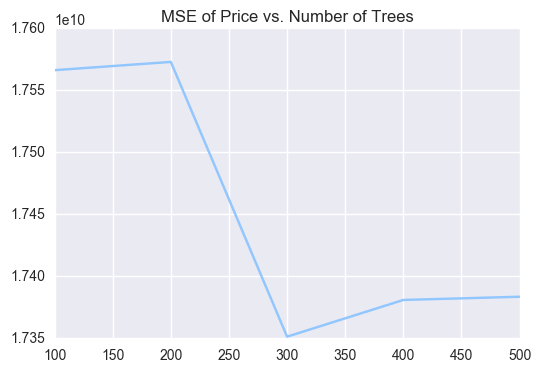

In [9]:
n_list = range(100, 600, 100)
mse_list = []
for n in n_list:
    m = RandomForestRegressor(n_estimators=n)
    mse_list.append(-np.mean(cross_val_score(m, train.iloc[:,3:], price_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')))
plt.plot(n_list, mse_list)
plt.title('MSE of Price vs. Number of Trees')

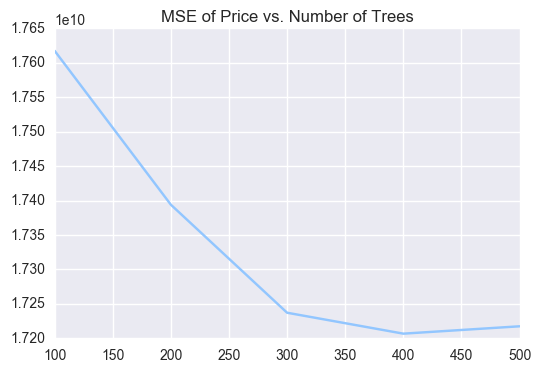

In [62]:
n_list = range(100, 600, 100)
mse_list = []
for n in n_list:
    m = RandomForestRegressor(n_estimators=n)
    mse_list.append(-np.mean(cross_val_score(m, train2, price_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')))
plt.plot(n_list, mse_list)
plt.title('MSE of Price vs. Number of Trees')

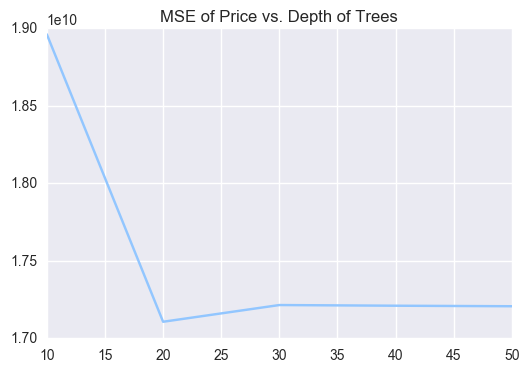

In [68]:
n = 400
d_list = range(10,60,10)
mse_list = []
for d in d_list:
    m = RandomForestRegressor(n_estimators=n, max_depth=d)
    mse_list.append(-np.mean(cross_val_score(m, train2, price_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')))
plt.plot(d_list, mse_list)
plt.title('MSE of Price vs. Depth of Trees')

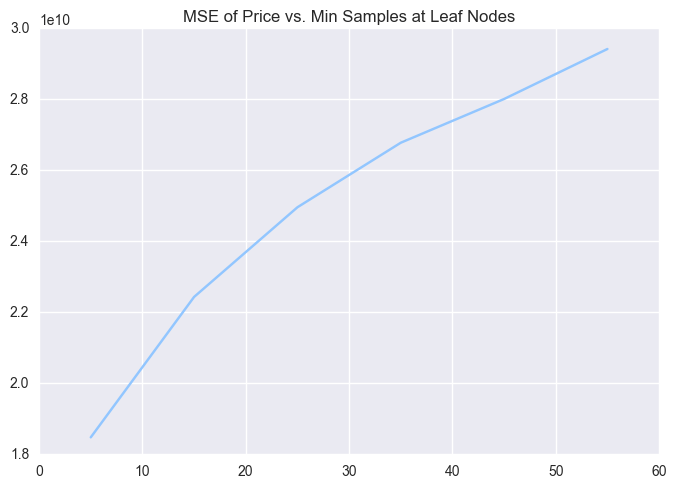

In [25]:
n = 400
d = 20
l_list = range(5,60,10)
mse_list = []
for l in l_list:
    m = RandomForestRegressor(n_estimators=n, max_depth=d, min_samples_leaf=l)
    mse_list.append(-np.mean(cross_val_score(m, train2, price_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')))
plt.plot(l_list, mse_list)
plt.title('MSE of Price vs. Min Samples at Leaf Nodes')

In [216]:
m2 = RandomForestRegressor(n_estimators=400, max_depth=20, max_features='sqrt')
m2.fit(train2, price_train)
price_rf_train = m2.predict(train2)
price_rf_pred = m2.predict(test2)
print 'Test RMSE of Sales Price: %d' % np.sqrt(mean_squared_error(price_test, price_rf_pred))
print 'Average Training Error: %.3f' % np.mean(np.true_divide(abs(price_train - price_rf_train), price_train))
print 'Average Test Error: %.3f' % np.mean(np.true_divide(abs(price_test - price_rf_pred), price_test))

Test RMSE of Sales Price: 122920
Average Training Error: 0.059
Average Test Error: 0.135


In [52]:
m5 = ExtraTreesRegressor(n_estimators=500, min_samples_split=5)
m5.fit(train2, price_train)
price_et_train = m5.predict(train2)
price_et_pred = m5.predict(test2)
print 'Test RMSE of Sales Price: %d' % np.sqrt(mean_squared_error(price_test, price_et_pred))
print 'Average Training Error: %.3f' % np.mean(np.true_divide(abs(price_train - price_et_train), price_train))
print 'Average Test Error: %.3f' % np.mean(np.true_divide(abs(price_test - price_et_pred), price_test))

Test RMSE of Sales Price: 115985
Average Training Error: 0.024
Average Test Error: 0.127


### Gradient Boosting

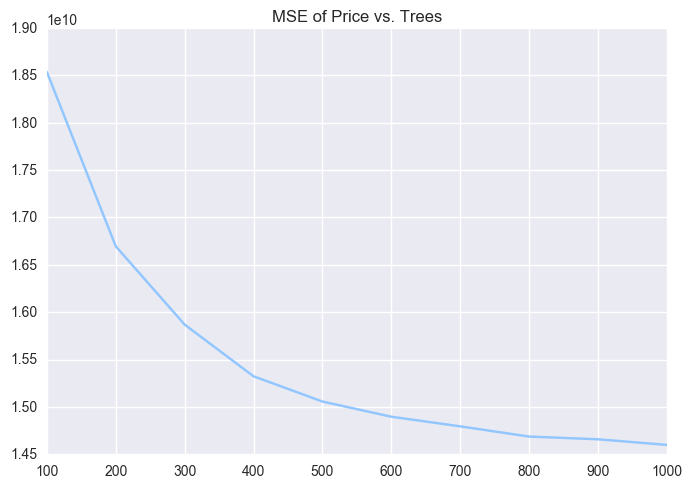

In [30]:
n = 400
d_list = range(100,1100,100)
mse_list = []
for d in d_list:
    m = GradientBoostingRegressor(n_estimators=d, learning_rate=0.1)
    mse_list.append(-np.mean(cross_val_score(m, train2, price_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')))
plt.plot(d_list, mse_list)
plt.title('MSE of Price vs. Trees')

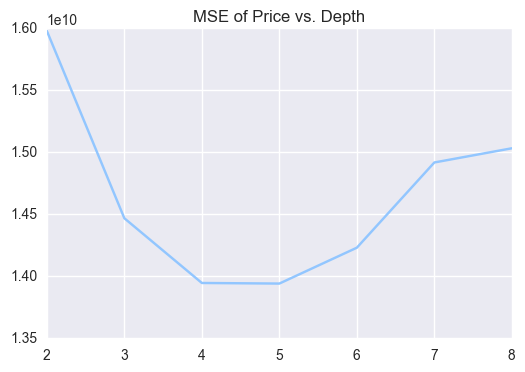

In [7]:
n = 1000
d_list = range(2,9)
mse_list = []
for d in d_list:
    m = GradientBoostingRegressor(n_estimators=n, learning_rate=0.1, max_depth=d)
    mse_list.append(-np.mean(cross_val_score(m, train2, price_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')))
plt.plot(d_list, mse_list)
plt.title('MSE of Price vs. Depth')

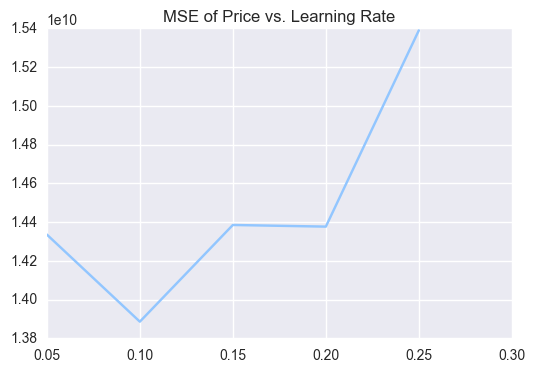

In [72]:
n = 1000
d = 5
lr_list = [0.05, 0.1, 0.15, 0.2, 0.25]
mse_list = []
for l in lr_list:
    m = GradientBoostingRegressor(n_estimators=n, learning_rate=l, max_depth=d)
    mse_list.append(-np.mean(cross_val_score(m, train2, price_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')))
plt.plot(lr_list, mse_list)
plt.title('MSE of Price vs. Learning Rate')

In [258]:
m3 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5)
m3.fit(train2, price_train)
price_sgb_train = m3.predict(train2)
price_sgb_pred = m3.predict(test2)
print 'Test RMSE of Sales Price: %d' % np.sqrt(mean_squared_error(price_test, price_sgb_pred))
print 'Average Training Error: %.3f' % np.mean(np.true_divide(abs(price_train - price_sgb_train), price_train))
print 'Average Test Error: %.3f' % np.mean(np.true_divide(abs(price_test - price_sgb_pred), price_test))

Test RMSE of Sales Price: 107537
Average Training Error: 0.087
Average Test Error: 0.120


In [293]:
m32 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5)
m32.fit(train2, sqftPrice_train)
sqftprice_sgb_train = m32.predict(train2)
price_sgb_train = sqftprice_sgb_train * train2['sqft_living']
sqftprice_sgb_pred = m32.predict(test2)
price_sgb_test = sqftprice_sgb_pred * test2['sqft_living']
print 'Test RMSE of Sales Price: %d' % np.sqrt(mean_squared_error(price_test, price_sgb_pred))
print 'Average Training Error: %.4f' % np.mean(np.true_divide(abs(price_train - price_sgb_train), price_train))
print 'Average Test Error: %.4f' % np.mean(np.true_divide(abs(price_test - price_sgb_pred), price_test))

Test RMSE of Sales Price: 107537
Average Training Error: 0.0843
Average Test Error: 0.1205


### Neural Networks

In [314]:
m4 = MLPRegressor(hidden_layer_sizes=(100,100,100), activation='relu', alpha=0.25, max_iter=500, learning_rate_init=0.05)
m4.fit(train_s, price_train)
price_nn_train = m4.predict(train_s)
price_nn_pred = m4.predict(test_s)
print 'Test RMSE of Sales Price: %d' % np.sqrt(mean_squared_error(price_test, price_nn_pred))
print 'Average Training Error: %.3f' % np.mean(np.true_divide(abs(price_nn_train - price_train), price_train))
print 'Average Test Error: %.3f' % np.mean(np.true_divide(abs(price_test - price_nn_pred), price_test))

Test RMSE of Sales Price: 112224
Average Training Error: 0.130
Average Test Error: 0.137


### Emsemble

#### Stack with Linear Combiner

In [316]:
#dist_train = [np.mean(x) for x in m1.kneighbors()[0]]
#dist_test = [np.mean(x) for x in m1.kneighbors(knn_test)[0]]
combine_train = np.column_stack((price_sgb_train, price_nn_train, price_knn_train, price_rf_train, dist_train))
combine_test = np.column_stack((price_sgb_pred, price_nn_pred, price_knn_pred, price_rf_pred, dist_test))
#combine_train = np.column_stack((price_sgb_train, price_rf_train, price_sgb_train*dist_train, price_rf_train*dist_train, price_knn_train, price_knn_train-price_knn_train*dist_train))
#combine_test = np.column_stack((price_sgb_pred, price_rf_pred, price_sgb_pred*dist_test, price_rf_pred*dist_test, price_knn_pred, price_knn_pred-price_knn_pred*dist_test))
scaler2 = StandardScaler()
combine_train = scaler2.fit_transform(combine_train)
combine_test = scaler2.transform(combine_test)
combiner = Ridge(alpha=1000)
combiner.fit(combine_train, price_train)
price_fit = combiner.predict(combine_train)
price_pred = combiner.predict(combine_test)
print 'Test RMSE of Sales Price: %d' % np.sqrt(mean_squared_error(price_test, price_pred))
print 'Average Training Error: %.4f' % np.mean(np.true_divide(abs(price_fit - price_train), price_train))
print 'Average Test Error: %.4f' % np.mean(np.true_divide(abs(price_test - price_pred), price_test))

Test RMSE of Sales Price: 106066
Average Training Error: 0.0536
Average Test Error: 0.1181


#### Stack with Neural Network

In [227]:
dist_train = [np.mean(x) for x in m1.kneighbors()[0]]
dist_test = [np.mean(x) for x in m1.kneighbors(knn_test)[0]]
combine_train = np.column_stack((price_sgb_train, price_nn_train, price_knn_train, price_rf_train, dist_train))
combine_test = np.column_stack((price_sgb_pred, price_nn_pred, price_knn_pred, price_rf_pred, dist_test))
scaler2 = StandardScaler()
combine_train = scaler2.fit_transform(combine_train)
combine_test = scaler2.transform(combine_test)
combiner = MLPRegressor(hidden_layer_sizes=(100,100), activation='relu', alpha=1, max_iter=500, learning_rate_init=0.01)
combiner.fit(combine_train, price_train)
price_fit = combiner.predict(combine_train)
price_pred = combiner.predict(combine_test)
print 'Test RMSE of Sales Price: %d' % np.sqrt(mean_squared_error(price_test, price_pred))
print 'Average Training Error: %.3f' % np.mean(np.true_divide(abs(price_fit - price_train), price_train))
print 'Average Test Error: %.3f' % np.mean(np.true_divide(abs(price_test - price_pred), price_test))

Test RMSE of Sales Price: 115973
Average Training Error: 0.024
Average Test Error: 0.125


In [285]:
combiner.coef_

array([ 123989.90513444,   39336.60992979,   16977.9559747 ,
        178840.40560855])